In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams.update({'text.usetex': True})

# design reverse integrability

In [34]:
fname="./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_4096_NP_512_retrace.hdf5"
myfile= h5py.File(fname, 'r')

In [35]:
myfile.keys()

<KeysViewHDF5 ['comptimeorbit', 'comptimeretrace', 'comptimestream', 'hostorbit', 'stream_retrace', 'streamfinal', 'streaminitial', 'tesc', 'timestamps', 'timestamps_stream']>

In [36]:
myfile.attrs.keys()

<KeysViewHDF5 ['GCname', 'date', 'hostparams', 'integrationparameters', 'machine', 'note', 'platform', 'potentialname', 'potentialparams', 'processor', 'python_version']>

In [37]:
comptimeretrace = myfile['comptimeretrace'][()]
print("comptimeorbit", myfile['comptimeorbit'][()])
print("comptimestream", myfile['comptimestream'][()])
print("comptimeretrace", myfile['comptimeretrace'][()])
stream_retrace = myfile['stream_retrace'][:]
streamfinal = myfile['streamfinal'][:]
streaminitial = myfile['streaminitial'][:]
hostorbit = myfile['hostorbit'][:]
streaminitial = streaminitial + hostorbit[:,0][:, np.newaxis]
integrationparameters = myfile.attrs['integrationparameters']
hostparams = myfile.attrs['hostparams']
staticgalaxy = myfile.attrs['potentialname'],myfile.attrs['potentialparams']
GCname = myfile.attrs['GCname']

comptimeorbit 0.00917
comptimestream 0.652214
comptimeretrace 0.607935


In [38]:
dt = integrationparameters[1]
tau=np.sqrt(hostparams[2]**3/(hostparams[0]*hostparams[1]))
alpha = dt/tau
alpha
# Calculate the number of timesteps per dynamical time
n_steps_per_tau = tau / dt

# Format alpha (dt/tau) in scientific notation
mantissa =  10**(int(np.floor(np.log10(abs(alpha)))))
exponent = int(np.floor(np.log10(abs(alpha))))
alpha_formatted = r"${:.1f} \times 10^{{{}}}$".format(mantissa*10, exponent-1)

print(f"Timestep: dt = {dt}")
print(f"Dynamical time: τ = {tau:.5f}")
print(f"Number of steps per dynamical time: {n_steps_per_tau:.1f}")
print(f"Ratio dt/τ = {alpha_formatted}")

boost = 1
matissa = 10**(np.log10(alpha) - int(np.log10(alpha)) + boost)
exponent = int(np.log10(alpha)) - boost
alpha_formatted = r"$\Delta t = {:.1f} \times 10^{{{}}} \tau$".format(matissa, exponent)
print(f"Boosted ratio dt/τ = {alpha_formatted}")
text_comp_time = r"$\mathrm{{Comp~time}} = {:.2f}~\mathrm{{s}}$".format(comptimeretrace)
integrationtime=integrationparameters[-1]*integrationparameters[1]
NSTEPS = int(integrationparameters[-1])
integrationtime=integrationtime*(u.s * (u.kpc/u.km))
integrationtime = integrationtime.to(u.Myr)
text_integration_time = r"$\mathrm{{T}} = {:.0f}~\mathrm{{Myr}}$".format(integrationtime.value)
print(text_comp_time)
print(text_integration_time)
image_name = "NumericalErrorStreamRetrace_{:s}_Nsteps_{:d}_stepsPerTau_{:d}.png".format(GCname, NSTEPS, int(n_steps_per_tau))

Timestep: dt = 0.000244140625
Dynamical time: τ = 0.00030
Number of steps per dynamical time: 1.2
Ratio dt/τ = $1.0 \times 10^{-2}$
Boosted ratio dt/τ = $\Delta t = 8.2 \times 10^{-1} \tau$
$\mathrm{Comp~time} = 0.61~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$


In [39]:
phiMW0, phiHost0, T0 = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], streaminitial)
phiMWstream, phiHoststream, Tstream = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,-1], streamfinal)
phiMWR, phiHostR, TR = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], stream_retrace)
E0 = phiMW0 + phiHost0 + T0
Estream = phiMWstream + phiHoststream + Tstream
ER = phiMWR + phiHostR + TR

errEFinal = np.abs((Estream - E0)/E0)
errERetrace = np.abs((ER - E0)/E0)

In [40]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Accent.colors)

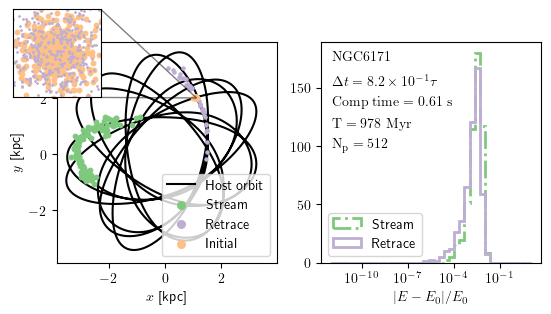

In [41]:
# fig,axis= plt.subplots(1,1,figsize=((8.25-2),(8.25-2)/2))
fig = plt.figure(figsize=(8.25-2, 4.5))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
axis = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], )
axis.plot(hostorbit[0,6:], hostorbit[1,6:], 'k-', label='Host orbit',zorder=0)
scatStream=axis.scatter(streamfinal[0], streamfinal[1], s=10, label='Stream')
scatRetrace=axis.scatter(stream_retrace[0], stream_retrace[1], s=5, label='Retrace')
scatInit=axis.scatter(streaminitial[0],  streaminitial[1], s=10,  label='Initial')
# Also make markers in the inset legend bigger if needed
xymin = np.min([axis.get_xlim()[0], axis.get_ylim()[0]])
xymax = np.max([axis.get_xlim()[1], axis.get_ylim()[1]])
axis.set_xlim(xymin, xymax)
axis.set_ylim(xymin, xymax)

# add a subplot that zooms on the retrace positions
axins = axis.inset_axes([-0.2, 0.75, 0.4, 0.4])  # [x0, y0, width, height]
axins.scatter(streaminitial[0],   streaminitial[1], s=10, c=scatInit.get_edgecolor(), label='Stream initial positions')
axins.scatter(stream_retrace[0], stream_retrace[1], s=1, c=scatRetrace.get_edgecolor(), label='Stream retrace positions')
axins.set_aspect('equal', adjustable='box')
# Add indicator lines from the main plot to the inset
axis.indicate_inset_zoom(axins, edgecolor="black")
# only do a couple characteristic radii
hostparams[-1]
radius = 2*hostparams[-1]
axins.set_xlim(hostorbit[0,0] + - radius, hostorbit[0,0]  + radius)
axins.set_ylim(hostorbit[1,0] + - radius, hostorbit[1,0]  + radius)
axins.set_xticks([])
axins.set_yticks([])

# Make markers in legend bigger
axis.legend(loc='lower right')
axis.set_aspect('equal', )
axis.set_xlabel(r'$x$ [kpc]')
axis.set_ylabel(r'$y$ [kpc]')
legend = axis.legend(loc='lower right')
for handle in legend.legend_handles:
    handle._sizes = [30]


bins = np.logspace(-12,1,40)
ax2.hist(errEFinal,bins=bins, histtype='step', color=scatStream.get_facecolor(), lw=2, label='Stream', linestyle='-.');
ax2.hist(errERetrace,bins=bins, histtype='step', color=scatRetrace.get_facecolor(), lw=2, label='Retrace', linestyle='-');
ax2.set_xscale('log')

ax2.set_xlabel(r'$|E - E_0| / E_0$')
ax2.legend(loc="lower left")

# Make sure ax2 has the same height as axis
ax2.set_position([ax2.get_position().x0, 
                 axis.get_position().y0, 
                 ax2.get_position().width, 
                 axis.get_position().height])
ax2.text(0.05, 0.9, r"$\mathrm{{{:s}}}$".format(GCname), transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.8, alpha_formatted, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.7, text_comp_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.6, text_integration_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.5, r"$\mathrm{{N}}_\mathrm{{p}} = {:d}$".format(int(streamfinal.shape[1])), transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")

fig.savefig("../../images/"+image_name, bbox_inches='tight', dpi=300)